In [1]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)

In [36]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures/builds_selection_per_release"

In [3]:
import git
git = git.Git("../../../sonarqube/") 

# Goal

In this notebook we will analyse the jobs and builds associated to the tags via the commit difference with the previous tag. We will investigate what jobs and builds will be left out from the association and implement algorithms to refine our selection of jobs based on PRs and FixVersions

### Import builds and jobs

In [29]:
builds = pd.read_csv(f"{csv_folder}/builds_cleaned.csv", index_col=0)

In [5]:
jobs = pd.read_csv(f"{csv_folder}/allJobs.csv", index_col=0)
for datefield in ["started_at","created_at","finished_at","updated_at"]:
    jobs[f"{datefield}"] = pd.to_datetime(jobs[f"{datefield}"])
jobs

,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url
0,241946101,241946099,2017-06-12 09:21:03+00:00,2017-06-12 09:13:51.063000+00:00,2017-06-12 09:21:43+00:00,25614.1,canceled,2018-06-02 14:51:19.734000+00:00,2e4b539138fde6f664a865c81fb6ab0763f74bdb,70181895,SONAR-9304 Add test on organization deletion,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
1,241946103,241946099,2017-06-12 09:22:43+00:00,2017-06-12 09:13:51.107000+00:00,2017-06-12 09:21:43+00:00,25614.2,canceled,2018-06-02 14:51:19.764000+00:00,2e4b539138fde6f664a865c81fb6ab0763f74bdb,70181895,SONAR-9304 Add test on organization deletion,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
2,241952024,241952022,2017-06-12 09:36:43+00:00,2017-06-12 09:32:52.227000+00:00,2017-06-12 09:37:23+00:00,25615.1,canceled,2018-06-02 14:51:25.661000+00:00,464f5da96733c14818f4b4bfeb878951b859ee0c,70183628,SONAR-9304 Add comments to make tests clearer,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
3,241952025,241952022,NaT,2017-06-12 09:32:52.237000+00:00,2017-06-12 09:37:24+00:00,25615.2,canceled,2018-06-02 14:51:25.669000+00:00,464f5da96733c14818f4b4bfeb878951b859ee0c,70183628,SONAR-9304 Add comments to make tests clearer,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
4,241952045,241952044,2017-06-12 09:42:16+00:00,2017-06-12 09:32:59.994000+00:00,2017-06-12 09:53:48+00:00,25616.1,passed,2018-06-02 14:51:26.125000+00:00,7358e9a93e47ac9fcaebe960c00ab8bd28e9890e,70183633,SONAR-9304 Add comments to make tests clearer,refs/pull/2104/merge,https://github.com/SonarSource/sonarqube/pull/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136978,315411337,315411335,2017-12-12 15:23:15+00:00,2017-12-12 15:22:41.091000+00:00,2017-12-12 15:26:39+00:00,34811.2,passed,2018-06-03 16:57:36.971000+00:00,abd0650045b3fcc95ac8459a6fc2450a1bd889c0,93642638,SONAR-10134 Fix ITs on quality gates by settin...,refs/pull/2866/merge,https://github.com/SonarSource/sonarqube/pull/...
136979,315421139,315421138,2017-12-12 15:43:05+00:00,2017-12-12 15:42:34.642000+00:00,2017-12-12 15:44:59+00:00,34812.1,passed,2018-06-03 16:57:47.762000+00:00,04d5e19040df59e2a4a1025514c9b8b7c42378f8,93645831,SONAR-10187 Provide more options to populate e...,refs/heads/feature/stas/MMF-1128,https://github.com/SonarSource/sonarqube/compa...
136980,315421140,315421138,2017-12-12 15:43:26+00:00,2017-12-12 15:42:34.682000+00:00,2017-12-12 15:44:25+00:00,34812.2,passed,2018-06-03 16:57:47.778000+00:00,04d5e19040df59e2a4a1025514c9b8b7c42378f8,93645831,SONAR-10187 Provide more options to populate e...,refs/heads/feature/stas/MMF-1128,https://github.com/SonarSource/sonarqube/compa...
136981,315421147,315421146,2017-12-12 15:43:25+00:00,2017-12-12 15:42:40.583000+00:00,2017-12-12 16:01:05+00:00,34813.1,passed,2018-06-03 16:57:47.837000+00:00,a5005e0ca38a67e7d70c255154990ed10be31020,93645838,SONAR-10187 Provide more options to populate e...,refs/pull/2895/merge,https://github.com/SonarSource/sonarqube/pull/...


In [175]:
builds_sha = jobs[["buildid", "commitsha","commitid","commitmessage","commitref", "created_at"]]
#builds_sha = builds_sha.merge(builds[["buildid", "created_at"]], on="buildid")

In [176]:
builds_sha = builds_sha.drop_duplicates(subset=["buildid", "commitsha"],ignore_index=True)
builds_sha.shape

(39514, 6)

In [177]:
builds_sha.head()

,buildid,commitsha,commitid,commitmessage,commitref,created_at
0,241946099,2e4b539138fde6f664a865c81fb6ab0763f74bdb,70181895,SONAR-9304 Add test on organization deletion,refs/heads/feature/atlas/MMF-324/builtin-profiles,2017-06-12 09:13:51.063000+00:00
1,241952022,464f5da96733c14818f4b4bfeb878951b859ee0c,70183628,SONAR-9304 Add comments to make tests clearer,refs/heads/feature/atlas/MMF-324/builtin-profiles,2017-06-12 09:32:52.227000+00:00
2,241952044,7358e9a93e47ac9fcaebe960c00ab8bd28e9890e,70183633,SONAR-9304 Add comments to make tests clearer,refs/pull/2104/merge,2017-06-12 09:32:59.994000+00:00
3,241955852,00e86fd06991a1e54e3b17eb82f2532f85de6489,70184755,SONAR-9356 skipOnboardingTutorial updates user...,refs/heads/feature/jl/onboarding,2017-06-12 09:45:48.061000+00:00
4,241956721,b34d8845506f0de01138e525d118fe292d204334,70185018,SONAR-9363 Create a step to choose the technology,refs/heads/feature/stas/onboarding/tutorial,2017-06-12 09:48:49.511000+00:00


### Pull Requests commits

In [119]:
pr_commits = pd.read_csv(f"{csv_folder}/pr_commits.csv", index_col=0)

### Import tags

In [120]:
alltags = pd.read_csv(f"{csv_folder}/tags_no_rc_and_milestones.csv", index_col=0)
alltags.Date = pd.to_datetime(alltags.Date)
alltags.actual_release_date = pd.to_datetime(alltags.actual_release_date)
alltags["month"] = alltags.Date.dt.month
alltags["year"] = alltags.Date.dt.year
alltags.rename(columns={"Date":"release_date"}, inplace=True)
tags = alltags.tail(-1)
tags.head()

,actual_release_date,Tag,Sha,release_date,month,year,major_version,jira_version
1,NaT,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7
2,2015-04-23,5.1,4aa9af3a6a4362b61db365fba32eb0a55d411e7a,2015-04-02 08:09:45,4,2015,5,5.1
3,NaT,5.1.1,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,2015-06-02 08:34:06,6,2015,5,5.1.1
4,NaT,5.1.2,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,2015-07-27 08:03:21,7,2015,5,5.1.2
5,2015-11-26,5.2,f045be98be3ba032b6b19d71574038eeeb91803b,2015-11-02 08:56:19,11,2015,5,5.2


In [246]:
tags

,actual_release_date,Tag,Sha,release_date,month,year,major_version,jira_version
1,NaT,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7
2,2015-04-23,5.1,4aa9af3a6a4362b61db365fba32eb0a55d411e7a,2015-04-02 08:09:45,4,2015,5,5.1
3,NaT,5.1.1,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,2015-06-02 08:34:06,6,2015,5,5.1.1
4,NaT,5.1.2,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,2015-07-27 08:03:21,7,2015,5,5.1.2
5,2015-11-26,5.2,f045be98be3ba032b6b19d71574038eeeb91803b,2015-11-02 08:56:19,11,2015,5,5.2
6,2016-01-28,5.3,8db783e62b266eeb0d0b10dc050a7ca50e96c5d1,2016-01-08 10:09:15,1,2016,5,5.3
7,2016-04-01,5.4,7b02df9be3cd9448699b5857586e1c6e2b28c007,2016-03-08 15:48:19,3,2016,5,5.4
8,2016-05-19,5.5,5773a4aab0ef6c0de79d3038e82f8a051049d6d0,2016-05-02 14:09:29,5,2016,5,5.5
9,2016-06-08,5.6,074f3d1169f9688d15af4aff67e7e672cbeed782,2016-06-01 11:59:09,6,2016,5,5.6
10,NaT,5.6.1,4f37a3f3b40da4bba953d1ed9a2b0d114869a8ad,2016-07-25 08:13:12,7,2016,5,5.6.1


### Import tag comparison pairs

In [121]:
tags_comparison = pd.read_csv(f"{csv_folder}/tags_comparison_final_updated_no_rc_and_milestones.csv", index_col=0)
tags_comparison.from_commit_date = pd.to_datetime(tags_comparison.from_commit_date)
tags_comparison.to_commit_date = pd.to_datetime(tags_comparison.to_commit_date)
tags_comparison.from_author_date = pd.to_datetime(tags_comparison.from_author_date)
tags_comparison.to_author_date = pd.to_datetime(tags_comparison.to_author_date)
#removing first 3 tags
tags_comparison = tags_comparison.tail(-3)
tags_comparison.to_tag

3       5.2
4       5.3
5       5.4
6       5.5
7       5.6
8     5.6.1
9     5.6.2
10      6.0
11    5.6.3
12    5.6.4
13    5.6.5
14    5.6.6
15    5.6.7
16      6.1
17    6.1.1
18      6.2
19      6.3
20    6.3.1
21    6.3.2
22      6.4
23      6.5
24      6.6
25      6.7
26    6.7.1
27      7.0
28    6.7.2
29    6.7.3
30    6.7.4
31    6.7.5
32    6.7.6
33    6.7.7
34      7.1
35      7.2
36      7.3
37      7.4
38      7.5
39      7.6
40      7.7
41      7.8
42      7.9
43    7.9.1
44      8.0
45    7.9.2
46    7.9.3
47    7.9.4
48      8.1
49      8.2
50      8.3
51    8.3.1
52      8.4
53    8.4.1
54    8.4.2
Name: to_tag, dtype: object

### Import issues

In [122]:
issues = pd.read_csv(f"{csv_folder}/issues_community.csv", index_col=0)
for date_field in ["created", "duedate", "lastViewed", "resolutiondate", "updated"]:
    issues[date_field] = pd.to_datetime(issues[date_field], errors="coerce")
issues = issues[issues.created > '2015-03-17 15:04:32+0000']
issues.head()

,issue_key,issue_id,issuetype,customfield_12130,customfield_11041,customfield_12132,customfield_12131,project,customfield_12134,customfield_12530,fixVersions,customfield_12133,customfield_12136,customfield_12532,resolution,customfield_10431,customfield_12135,customfield_12531,customfield_12138,customfield_10432,customfield_12534,customfield_12137,customfield_10433,customfield_12533,customfield_11832,customfield_11831,customfield_11833,resolutiondate,workratio,lastViewed,watches,created,customfield_11032,customfield_11033,priority,edition,customfield_11233,customfield_11036,customfield_11830,labels,customfield_11631,customfield_11038,customfield_10930,customfield_11347,customfield_10931,customfield_10932,versions,issuelinks,assignee,updated,status,components,customfield_12031,customfield_11140,customfield_12030,customfield_12033,customfield_11141,description,customfield_12032,customfield_12034,customfield_12430,customfield_11344,customfield_11343,customfield_10530,customfield_11345,customfield_10730,customfield_11337,customfield_11930,customfield_11139,customfield_11338,summary,creator,subtasks,customfield_11130,customfield_11131,reporter,customfield_11132,customfield_11133,customfield_10243,customfield_11335,customfield_11334,customfield_11730,customfield_10434,customfield_12536,customfield_12535,customfield_12139,environment,customfield_12538,customfield_10437,customfield_12537,customfield_10438,duedate,votes,issuetype_id,issuetype_name,priority_id,priority_name,assignee_key,assignee_name,reporter_key,reporter_name,creator_key,creator_name,status_id,status_name,resolution_id,resolution_name,votes_votes
1,SONAR-14168,99609,Sub-task,P3-Medium,0|i0duvz:,No root cause identified,NaN,SONAR,Not captured yet,NaN,[],Not assessed yet,Not captured yet,NaN,Fixed,NaN,No action plan,NaN,Not captured yet,NaN,NaN,Not captured yet,NaN,NaN,NaN,NaN,NaN,2020-11-19 14:02:04+00:00,-1,NaT,<JIRA Watchers at 5037154944>,2020-11-19 11:10:36+00:00,NaN,NaN,Major,Community,NaN,NaN,NaN,[],None,NaN,NaN,NaN,NaN,NaN,[],[],Jeremy Davis,2020-11-19 14:02:04+00:00,Resolved,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,SonarQube,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,[UI] Realign projects' API,Jeremy Davis,[],NaN,NaN,Jeremy Davis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NaN,NaN,NaN,NaN,,NaN,[],2020-11-26 00:00:00+00:00,0,5,Sub-task,3,Major,jeremy.davis,jeremy.davis,jeremy.davis,jeremy.davis,jeremy.davis,jeremy.davis,5,Resolved,1.0,Fixed,0
2,SONAR-14167,99607,Documentation,P3-Medium,0|i0duvj:,No root cause identified,NaN,SONAR,Not captured yet,NaN,"[<JIRA Version: name='8.6', id='16435'>]",Not assessed yet,Not captured yet,NaN,NaN,NaN,No action plan,NaN,Not captured yet,NaN,NaN,Not captured yet,NaN,NaN,NaN,NaN,NaN,NaT,-1,NaT,<JIRA Watchers at 5037155760>,2020-11-19 09:46:02+00:00,NaN,NaN,Major,Community,NaN,NaN,NaN,[],None,NaN,NaN,NaN,NaN,NaN,[],[<JIRA IssueLink: id='55366'>],Mike Birnstiehl,2020-11-19 09:46:47+00:00,Open,"[<JIRA Component: name='Documentation', id='11...",NaN,NaN,NaN,NaN,NaN,* Add insights on how to quickly analyze a pro...,NaN,SonarQube,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,Improve the Azure DevOps integration page,Philippe Perrin,[],NaN,NaN,Philippe Perrin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NaN,NaN,NaN,NaN,,NaN,[],NaT,0,6,Documentation,3,Major,michael.birnstiehl,michael.birnstiehl,philippe.perrin,philippe.perrin,philippe.perrin,philippe.perrin,1,Open,NaN,NaN,0
3,SONAR-14166,99584,Task,P3-Medium,0|i0duqf:,No root cause identified,NaN,SONAR,Not captured yet,NaN,"[<JIRA Version: name='8.6', id='16435'>]",Not assessed yet,Not captured yet,NaN,NaN,NaN,No action plan,NaN,Not captured yet,NaN,NaN,Not captured yet,NaN,NaN,NaN,NaN,NaN,NaT,-1,NaT,<JIRA Watchers at 5037157008>,2020-11-18 13:24:30+00:00,NaN,NaN,Major,Community,NaN,NaN,NaN,['analyzer-upgrade'],None,NaN,NaN,NaN,NaN,NaN,[],[],NaN,2020-11-18 13:25:07+00:00,Open,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,SonarQube,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,Improve LITS analysis,Malena Ebert,[],NaN,NaN,SonarQube Technical user,NaN,NaN,

In [123]:
issues.shape

(4656, 108)

### Import issue versions

In [124]:
versions = pd.read_csv(f"{csv_folder}/issues_versions.csv", index_col=0)
versions.head()

,issue_id,version_name,version_id
0,99500,8.5,16342
1,99361,8.5,16342
2,99004,8.5.1,16458
3,98951,8.4,15833
4,98652,8.1,15243


### Import issue fixversions

In [125]:
fix_versions = pd.read_csv(f"{csv_folder}/issues_fixversions.csv", index_col=0)
fix_versions.head()

,issue_id,fixVersion_name,fixVersion_id
0,99607,8.6,16435
1,99584,8.6,16435
2,99583,8.6,16435
3,99582,8.6,16435
4,99581,8.6,16435


### Import Pull request data

In [126]:
prs = pd.read_csv(f"{csv_folder}/prs.csv", index_col=0)
prs.created_at = pd.to_datetime(prs.created_at)
prs.closed_at = pd.to_datetime(prs.closed_at)

In [127]:
prs

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
0,2015,SONAR-9122 prevent setting a project as private,2017-05-03 12:26:16+00:00,2017-05-04 09:19:56+00:00,closed,True,e10f04d5b4055e2813ac01a811b325a414797c4e,b10cb50ec7c26a85dd549de6633e60705994bd66,master,13bb5a131e0fa2c20f041d4e8c79e847fc601348,feature/stas/lock-private-projects
1,2008,Upgrade scanner in performance tests,2017-05-02 19:17:44+00:00,2017-05-04 11:50:06+00:00,closed,False,492bb4ff488ee992a3708622ca9a6be88ee7f11a,7b2958e443c4c629f3e35aba7182d7cb524b250b,master,9a90c2f7097fab8fe94681b1e7ea09294a308314,feature/sb/sonar-runner-in-its
2,2026,SQ 6.4 web hardening 5,2017-05-04 15:17:16+00:00,2017-05-09 09:14:37+00:00,closed,True,ab64e97deecaf047d85debdd1ba669e1d4071d51,87d60ccc748d84f55f7c102b6ec6d489215eef8f,master,368935160f780caf8a9b7ff250606e84c68c50cb,feature/greg/6.4_web_hardening_5
3,2046,Hardening Wednesday,2017-05-10 11:54:28+00:00,2017-05-11 08:56:18+00:00,closed,False,041ee672ade0c77d75db0ca379bad255936d9730,7f939f50b63f7c6ac7aab6d8fbb71a06193df0be,master,285e16edf389aa34db2bc2f0ce99a2e3042f3f32,feature/tb/hardening-wednesday
4,2021,SONAR-6135 Upgrade MySQL driver to 5.1.42,2017-05-04 07:42:23+00:00,2017-05-04 12:52:45+00:00,closed,True,5e1fdd17e3147180e3a4273705835e2fc393ae20,6d18fa56e8782e022169738587750dfe59b4015a,master,da23d42a0af4db59d7aeac71dd51f659b43f763b,feature/eh/SONAR-6135
...,...,...,...,...,...,...,...,...,...,...,...
3244,610,SONAR-6919 Enforce some mandatory web service ...,2015-11-02 16:09:25+00:00,2015-11-05 14:52:07+00:00,closed,False,5da330ecc08721aca649a4a401e89149d267b42d,526e3b9053582e4921d705c35a4b24d3cd9d0d60,master,526e3b9053582e4921d705c35a4b24d3cd9d0d60,feature/ws_enforce_mandatory_fields
3245,620,SONAR-6922 Initial version of report viewer,2015-11-06 10:13:57+00:00,2015-11-09 07:40:54+00:00,closed,True,15f6f81f1ff387f387bca18342301a2e88877060,7567526369d1082a8023623c016b970cac314c64,master,eb5fd4fe77eb1b82b3aa5e1c3474d85ac39ee9ce,feature/report_viewer
3246,639,SONAR-7027 Add developer concept in CE,2015-11-18 14:03:35+00:00,2015-11-19 13:48:15+00:00,closed,True,a8ce34fd965d2ea0e212b3576666ee594459f8c5,30e7baee5a1785168c2e2c2bcea73ae1a78087da,master,240cf9f64ff0d7aa1e94f4fdeeb449f48141bcb0,feature/introduce_dev_in_ce
3247,602,SONAR-6834 Purge CE_ACTIVITY when deleting a p...,2015-10-27 10:31:24+00:00,2015-10-27 11:07:27+00:00,closed,False,68c6fe12c4df2678e1a0ca8d60afb300b0faba50,19350f7eb06f0f46674ad394e0919edbae2b2a2a,branch-5.2,8d809c371e9b00c1886b1f7e83d8699e546bdb0e,feature/delete_ce_activity_when_del_project


### Commitmessages

In [128]:
def get_commit_message(sha):
    return git.log("--pretty=oneline","-n 1",sha).replace(f"{sha} ", "")

tags_comparison_commits["commit_message"] = tags_comparison_commits.ahead_sha.apply(get_commit_message)

tags_comparison_commits.to_csv(f"{csv_folder}/tags_comparison_commits_no_rc_and_milestones_with_commitmessages.csv")

### Changes made by each commit (for cherry picking detection)

In [129]:
def get_files_changed(sha):
    try:
        files = git.log("--pretty=oneline","--name-status", "-n 1",sha).split("\n")[1:]
        return "\n".join(files)
    except:
        #print("An error occured", sha)
        return None

from pandarallel import pandarallel
pandarallel.initialize()
tags_comparison_commits["files_changed"] = tags_comparison_commits.ahead_sha.parallel_apply(get_files_changed)

tags_comparison_commits.to_csv(f"{csv_folder}/tags_comparison_commits_no_rc_and_milestones_with_commitmessages_and_files_changed.csv")

### Commit dates

In [130]:
def get_commit_date(sha):
    try:
        return git.show("--no-patch", "--no-notes", "--pretty='%cI'",sha)
    except:
        #print("An error occured", sha)
        return None

commits_dates = pd.read_csv(f"{csv_folder}/commits_dates.csv", index_col=0)

commits_left = tags_comparison_commits.ahead_sha.append(jobs.commitsha).drop_duplicates()
commits_left = commits_left[~commits_left.isin(commits_dates.commitsha)]
commits = commits_left.reset_index().rename(columns={0:"commitsha"}).drop(columns=["index"]).drop_duplicates(ignore_index=True)
commits.shape

from pandarallel import pandarallel
pandarallel.initialize()
commits["date"] = commits.commitsha.apply(get_commit_date)

commits["date"] = pd.to_datetime(commits["date"])

commits_dates = commits_dates.append(commits).drop_duplicates(ignore_index=True)

In [131]:
#commits_dates.to_csv(f"{csv_folder}/commits_dates.csv")
commits_dates = pd.read_csv(f"{csv_folder}/commits_dates.csv", index_col=0)
commits_dates = commits_dates.drop_duplicates(ignore_index=True)
commits_dates["date"] = pd.to_datetime(commits_dates["date"], errors='coerce')
commits_dates = commits_dates[~commits_dates.date.isna()]
commits_dates.shape

(15615, 2)

commits.to_csv(f"{csv_folder}/commits_dates.csv")

### Import tags commits difference

In [132]:
tags_comparison_commits = pd.read_csv(f"{csv_folder}/tags_comparison_commits_no_rc_and_milestones.csv", index_col=0)
tags_comparison_commits

,from_tag,to_tag,ahead_sha
0,4.5.6,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83
1,4.5.6,4.5.7,8cd20603bdbff2d725a3ba981839120b8d40faac
2,4.5.6,4.5.7,d0d9715a973793e5c8fc0ada606f70ffc7f08bf7
3,4.5.6,4.5.7,36d9a7959a95cbe44550e2c7790bf68d4c1066c8
4,4.5.6,4.5.7,75d7c7ff807aa0c081935fe8c93095277e6fe497
...,...,...,...
15600,8.4,8.4.1,08e36b12704d8ac30f56d3d5ecf73d5457424b5c
15601,8.4.1,8.4.2,2de1f343e3dbd9e88007b42e475512677c04eb8a
15602,8.4.1,8.4.2,ed1a72601c559e86ccd96004c99157421b6bcb20
15603,8.4.1,8.4.2,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df


In [133]:
#load comparison with the extra info
tags_comparison_commits = \
pd.read_csv(f"{csv_folder}/tags_comparison_commits_no_rc_and_milestones_with_commitmessages_and_files_changed.csv", index_col=0)

In [134]:
tags_comparison_commits.shape

(15605, 5)

### Import quality metrics

In [135]:
sw_quality_metrics = pd.read_csv(f"{csv_folder}/tags_software_quality_metrics_no_rc_and_milestones.csv", index_col=0)
sw_quality_metrics.head()

,version_name,post_release_bugs,pre_release_bugs,dde,critical_post_release_bugs,minor_post_release_bugs,fix_time
0,4.5.7,1.0,0.0,0.000000,0.0,0.0,434.286030
1,5.1,17.0,7.0,0.291667,0.0,1.0,76.542600
2,5.1.1,6.0,0.0,0.000000,0.0,0.0,18.665239
3,5.1.2,3.0,0.0,0.000000,0.0,0.0,103.197836
4,5.2,36.0,2.0,0.052632,0.0,3.0,63.796018


## Start

In [167]:
def get_prs_given_commits(commits):
    #print(commits)
    return prs[((prs.head_sha.isin(commits))|\
                       (prs.merge_commit_sha.isin(commits))) & (prs.merged)]

def get_builds_for_pull_request(pr_number):
    return builds_sha[(builds_sha.commitref==f"refs/pull/{pr_number}/merge")]

def get_builds_ids_for_head_branch_in_pr(prs):
    _j = set()
    for i, row in prs.iterrows():
        _i = builds_sha[(builds_sha.commitref==f"refs/heads/{row.head_ref}")\
                                         & (builds_sha.created_at < row.closed_at)].buildid.values.tolist()
        _m = builds_sha[(builds_sha.commitref==f"refs/pull/{row.pr_number}/merge")\
                                         & (builds_sha.created_at < row.closed_at)].buildid.values.tolist()
        _j = _j.union(_i).union(_m)
    return _j

**Pairs**

In [168]:
tags_comparison[["from_tag", "to_tag"]].sort_values(by="to_tag")

,from_tag,to_tag
3,5.1.2,5.2
4,5.2,5.3
5,5.3,5.4
6,5.4,5.5
7,5.5,5.6
8,5.6,5.6.1
9,5.6.1,5.6.2
11,5.6.2,5.6.3
12,5.6.3,5.6.4
13,5.6.4,5.6.5


### Count n of builds, jobs and merge requests per pair

In [220]:
direct_data = [] 
pr_data = []
def get_n_builds(row):
    commits = tags_comparison_commits[(tags_comparison_commits.from_tag == row.from_tag) & \
                                      (tags_comparison_commits.to_tag == row.to_tag)].ahead_sha
    b = builds_sha[builds_sha.commitsha.isin(commits)]
    for buildid in b.buildid:
        direct_data.append((row.from_tag, row.to_tag, buildid))
    return len(b)

In [221]:
tags_comparison["n_builds"] = tags_comparison.apply(get_n_builds,axis=1)

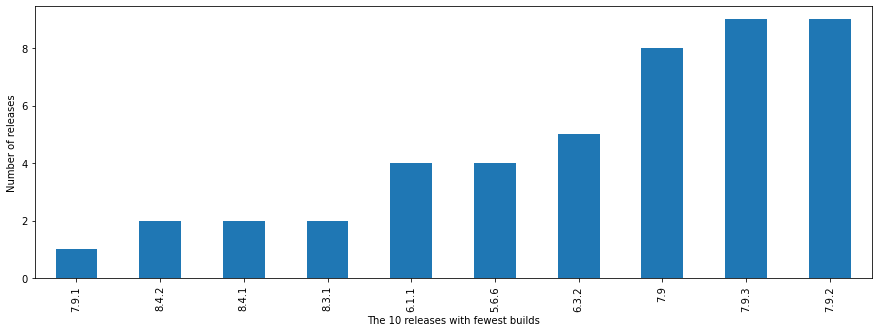

In [222]:
plt.figure()
ax =tags_comparison.set_index("to_tag")["n_builds"].sort_values().head(10).plot(kind="bar")
ax.set(xlabel="The 10 releases with fewest builds", ylabel="Number of releases")
plt.savefig(f"{figure_folder}/ahead_commits_builds_per_release.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Dataframes with job ids from difference commits and jobs ids from pull requests for each pair**

In [223]:
builds_from_direct = pd.DataFrame(direct_data, columns=["from_tag", "to_tag", "buildid"])
builds_from_direct.to_csv(f"{csv_folder}/builds_per_release/builds_from_direct.csv")

<AxesSubplot:>

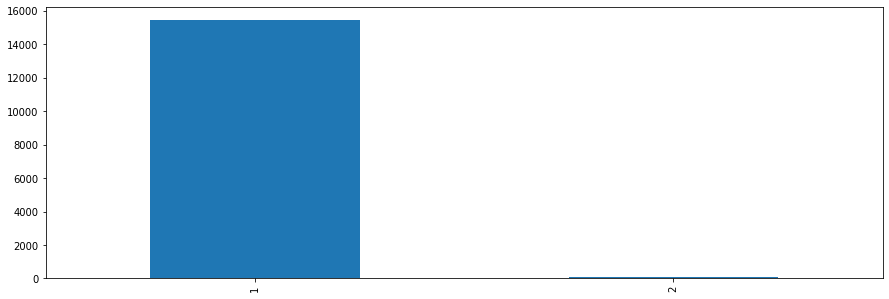

In [224]:
tags_comparison_commits.groupby(["ahead_sha"]).to_tag.count().value_counts().plot(kind="bar")

Text(0, 0.5, 'number of builds')

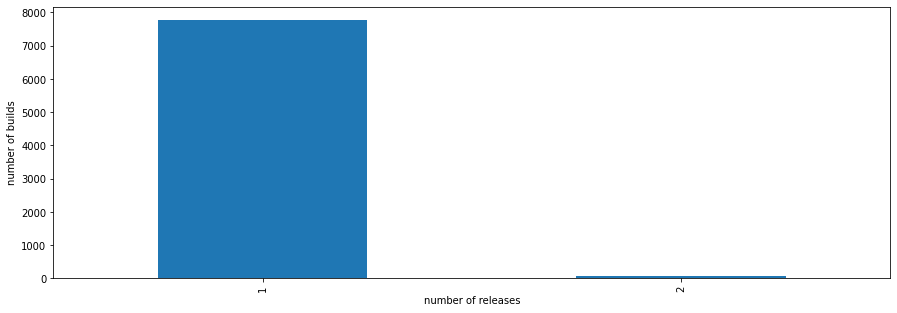

In [225]:
ax = builds_from_direct.groupby(["buildid"]).to_tag.count().value_counts().plot(kind="bar")
ax.set_xlabel("number of releases")
ax.set_ylabel("number of builds")

**How many jobs did we include**

In [237]:
len(set(builds_from_direct.buildid)) / builds_sha.buildid.nunique()

0.1987396871994736

### Pull request data

from :https://docs.travis-ci.com/user/pull-requests/#double-builds-on-pull-requests
* Rather than build the commits that have been pushed to the branch the pull request is from, we build the merge between the source branch and the upstream branch.

When only looking at the difference in commits between the two tags we may miss out on some pull request builds because Travis CI does not build the commits from the source branch (which are the commits we get as difference) but "fictive commits" which are the merge of the source and upstream branch.
Therefore in order to get a complete picture of the process of development of the release, we need to include these as well.

We do it by retrieving for each difference commit the pull request which match that commit in their head commit (the commit which is to be merged into the target branch in case of a fast forward) or in the merge_commit_sha. Once the list of pull requests is obtained, we query all the jobs which are associated with that pull request via its number.

In [228]:
pr_build_data = []
pr_data = []
def get_n_pull_request_jobs(row):
    _commits = tags_comparison_commits[(tags_comparison_commits.from_tag==row.from_tag) \
                                    & (tags_comparison_commits.to_tag==row.to_tag)].ahead_sha

    #commits_pr = pr_commits[pr_commits.commitsha.isin(tags_comparison_commits_example)]
    pull_requests = get_prs_given_commits(_commits)
    
    df = []
    for i, pr_number in enumerate(pull_requests.pr_number.unique()):
        if i == 0:
            df = get_builds_for_pull_request(pr_number)
        else:
            df = pd.concat([df, get_builds_for_pull_request(pr_number)]) 
        pr_data.append((row.from_tag, row.to_tag, pr_number))
    if(len(df)>0):
        for buildid in df.buildid:
            pr_build_data.append((row.from_tag, row.to_tag, buildid))
    return len(df)

In [229]:
tags_comparison["n_pull_request_builds"] = tags_comparison.apply(get_n_pull_request_jobs, axis=1)

In [230]:
tags_prs = pd.DataFrame(pr_data, columns=["from_tag", "to_tag", "pr_number"])
builds_from_direct_prs = pd.DataFrame(pr_build_data, columns=["from_tag", "to_tag", "buildid"])
builds_from_direct_prs.to_csv(f"{csv_folder}/builds_per_release/builds_from_direct_prs.csv")

Text(0, 0.5, 'number of builds')

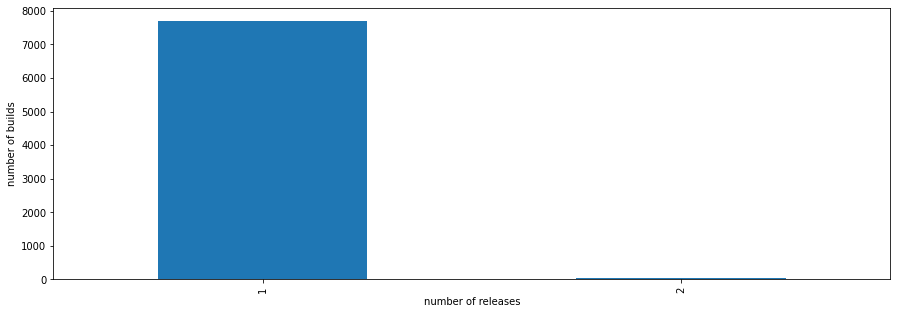

In [231]:
ax = builds_from_direct_prs.groupby(["buildid"]).to_tag.count().value_counts().plot(kind="bar")
ax.set_xlabel("number of releases")
ax.set_ylabel("number of builds")

<AxesSubplot:xlabel='to_tag'>

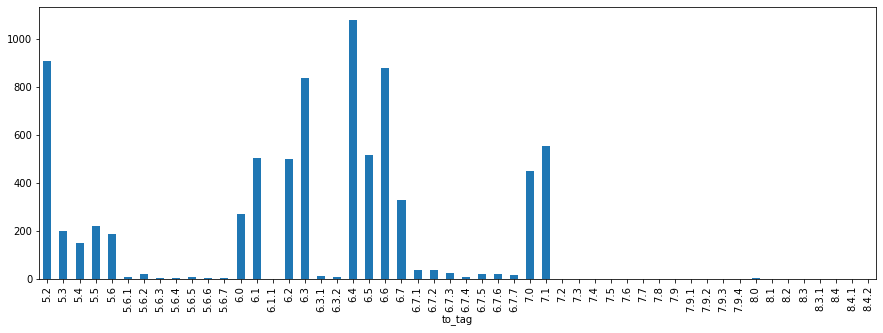

In [232]:
tags_comparison.set_index("to_tag").sort_index().n_pull_request_builds.plot(kind="bar")

In [236]:
builds_from_direct_direct_pr = builds_from_direct.append(builds_from_direct_prs)
builds_from_direct_direct_pr.buildid.nunique() / builds_sha.buildid.nunique()

0.39492331831755834

In [197]:
builds_from_direct_direct_pr.to_tag = builds_from_direct_direct_pr.to_tag.astype(str)

In [ ]:
tags_comparison["direct_pr_builds"] = tags_comparison.n_builds + tags_comparison.n_pull_request_builds

In [67]:
tags_comparison["direct_pr_builds"].describe()

count      52.000000
mean      628.557692
std      1190.073180
min         1.000000
25%        24.000000
50%        53.500000
75%      1109.500000
max      6801.000000
Name: direct_pr_builds, dtype: float64

<AxesSubplot:xlabel='direct_pr_builds'>

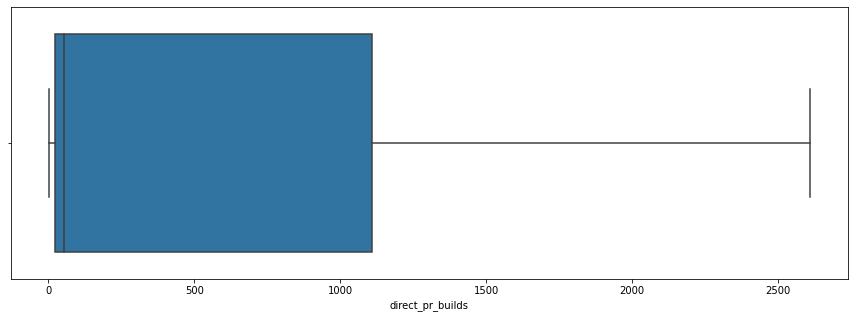

In [69]:
sns.boxplot(x=tags_comparison["direct_pr_builds"], showfliers=False)

In [72]:
builds_before_pr_data = []
def associated_builds_before_pr(row):    
    build_ids_prs = []
    _pr_numbers = tags_prs[(tags_prs.to_tag == row.to_tag) & (tags_prs.from_tag == row.from_tag)].pr_number
    _prs = prs[prs.pr_number.isin(_pr_numbers)]
    for i, pr in _prs.iterrows():
        if(pr.head_ref == "master"):
            print("Skipping master", row.from_tag, row.to_tag, pr.pr_number, pr.base_ref)
            continue
        build_ids_prs = builds_sha[(builds_sha.commitref==f"refs/heads/{pr.head_ref}") & (builds_sha.created_at < pr.closed_at)].buildid.values.tolist()
        for buildid in build_ids_prs:
            builds_before_pr_data.append((row.from_tag, row.to_tag, buildid))
    return len(builds_before_pr_data)

In [73]:
tags_comparison["n_builds_before_pr"] = tags_comparison.apply(associated_builds_before_pr, axis=1)

Skipping master 5.1.2 5.2 333 master
Skipping master 6.0 6.1 1194 master
Skipping master 6.0 6.1 1218 master
Skipping master 6.3.2 6.4 1843 master


In [76]:
builds_head_ref_before_pr = pd.DataFrame(builds_before_pr_data, columns=["from_tag", "to_tag", "buildid"])
builds_head_ref_before_pr.to_csv(f"{csv_folder}/builds_per_release/builds_head_ref_before_pr.csv")

Text(0, 0.5, 'number of builds')

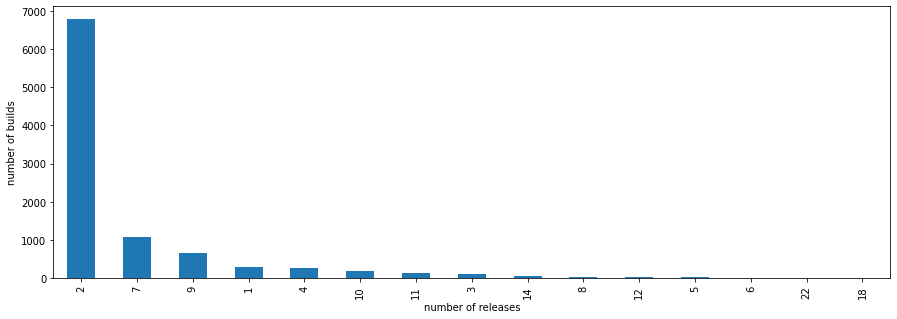

In [77]:
ax = builds_head_ref_before_pr.groupby(["buildid"]).to_tag.count().value_counts().plot(kind="bar")
ax.set_xlabel("number of releases")
ax.set_ylabel("number of builds")

**How many jobs do we leave out?**

In [78]:
builds_head_ref_before_pr_from_direct_direct_pr = builds_from_direct_direct_pr.append(builds_head_ref_before_pr)
x = builds_head_ref_before_pr_from_direct_direct_pr
len(set(x.buildid)) / builds.id.nunique()

0.6160721067422842

### Investigate PRs left out

In [79]:
prs_out = prs[(~prs.pr_number.isin(tags_prs.pr_number.unique()))\
              & (prs.created_at > pd.to_datetime("2015-03-15 00:00:00+00:00"))]

In [80]:
prs_out.merged.value_counts(normalize=True)

False    0.728358
True     0.271642
Name: merged, dtype: float64

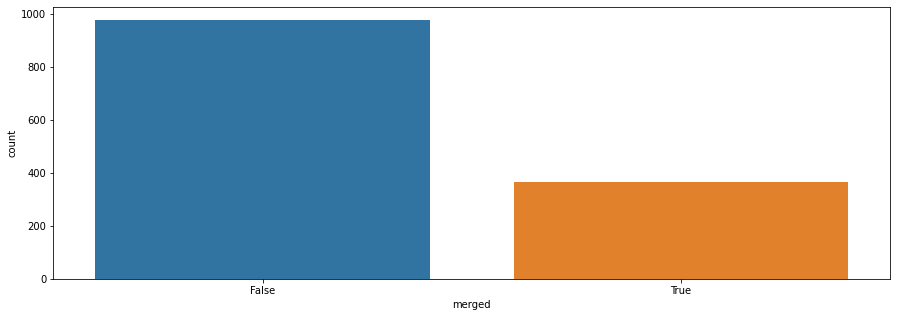

In [83]:
plt.figure()
sns.countplot(x=prs_out.merged)
plt.savefig(f"{figure_folder}/merged_prs.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Prs merged into master**

More likely to be detected by our approach

In [84]:
len(prs_out[(prs_out.merged==True) & \
    (prs_out.base_ref != "master")]) / len(prs_out[(prs_out.merged==True)])

0.9972527472527473

In [85]:
prs_out[(prs_out.merged==True) & \
    (prs_out.base_ref == "master")]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
444,3184,Corrected typo,2018-10-09 22:44:50+00:00,2018-10-15 18:50:28+00:00,closed,True,ed414e9ab4b47257bcf4e4462ee097dd4a2eb18a,a6e127b39f864078041f71552d51767f9bb374a5,master,e1f95b2763e52f72fbe855f170518a8621679f7e,patch-1


Indeed these left out pull requests look like they are merged into other master branches of other projects

**PRs not merged into master**

In [86]:
prs_out_not_master = prs_out[(prs_out.merged==True) & \
    (prs_out.base_ref != "master")]
#Prs from feature to feature
len(prs_out_not_master[(prs_out_not_master.head_ref.str.startswith("feature/"))\
                   & (prs_out_not_master.head_ref.str.startswith("feature/"))]) \
                   / len(prs_out_not_master)

0.9393939393939394

In [87]:
prs_out_not_master

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
250,2212,MMF-870 Apply feedbacks,2017-07-03 08:15:16+00:00,2017-07-03 10:25:30+00:00,closed,True,165ea2c44bb481c63fbb69e62eeaabe2b13ee380,9e5686fa47dc38b116020ec99b557432ac0b8600,feature/lambda/enhance_project_activity,1f66e0d73d7bbb106e0ff70af073f40f562ed7de,feature/greg/enhance_project_activity_feedback
255,2205,SONAR-9482 Display the number of 'Sonar way' r...,2017-06-29 11:52:38+00:00,2017-06-30 08:40:35+00:00,closed,True,0b8163856d3af6b0f99f60b8c84074daebe52e2d,b3cae67139df544ec8ef3d3e9cbaf9f48546c17a,feature/lambda/highlight_sonar_way_profile,92e8201451a7007d36c201a3a4d7056f07ef5191,feature/lambda/implement_qp_show_ws
260,2207,"SONAR-9483 Compare a profile with a ""Sonar way...",2017-06-30 08:44:13+00:00,2017-06-30 11:05:02+00:00,closed,True,601e89c0f429c7437360a3bcf96400c1314fdf8b,0b8163856d3af6b0f99f60b8c84074daebe52e2d,feature/lambda/highlight_sonar_way_profile,81e6304cb1d7b6b435e06d86ef7d6ababf1fb86a,feature/lambda/add_compare_to_in_rules_search
261,2226,SONAR-9403 Add custom graph to the project act...,2017-07-07 11:03:36+00:00,2017-07-11 09:13:08+00:00,closed,True,74c53b85629ef84e572a6c9a94cc2f52019c024a,784299357d62cfb87b1885bf3bb87dbc2ed3144d,feature/lambda/understand-history-project,5de233dc7d54131c7dc9d73ac664295da4c10bec,feature/greg/custom-graph-history-project
265,2206,Highlight sonar way quality profiles,2017-06-29 12:15:12+00:00,2017-06-30 06:34:51+00:00,closed,True,b3cae67139df544ec8ef3d3e9cbaf9f48546c17a,7497736b259aafd0457411343ec14993d3566a17,feature/lambda/highlight_sonar_way_profile,574e458f3601afc69c57045b03d1ccde566261c2,feature/greg/highlight_sonar_way_profile
267,2220,SONAR-9418 Add activity interaction,2017-07-05 15:01:50+00:00,2017-07-05 16:05:43+00:00,closed,True,8b48c420723ed51405ec3ed1ccd4b6b7a991e856,7bd9f008ca0d9bf1b5b6cb75d10ba0ce0dd281d1,feature/lambda/understand-history-project,9198a555bee1f96a06736d7ca568a84ad7a376a7,feature/greg/project_activity_interaction
269,2223,SONAR-9508 Create api/ce/worker_count WS,2017-07-06 08:21:33+00:00,2017-07-06 09:34:17+00:00,closed,True,1cd3c185bffd49a44c96f434a3d016893771ada1,fd6a1b6a1c24564077d7bf8d2595b6d470bc9aa5,feature/platform/move_worker_count_to_gov,b823e5205efcdef8214e0174693bd9e02c1ba596,feature/jl/create_worker_count_ws
275,2217,SONAR-9507 ce worker count as internal property,2017-07-04 16:23:24+00:00,2017-07-06 08:16:38+00:00,closed,True,b940617d5719963c8337886d13afe1b34fb2461b,2e3eb0e482ff93b5c30189eca126a58e45e9221a,feature/platform/move_worker_count_to_gov,b940617d5719963c8337886d13afe1b34fb2461b,feature/sl/SONAR-9507/ce_worker_count_as_inter...
277,2231,SONAR-9525 dynamic ce workers,2017-07-10 09:17:31+00:00,2017-07-11 15:06:59+00:00,closed,True,aba4c66e9a547a2b45fc26dced52014b948f95f4,7da4f278af130240bdab1e5b5729e4e9c0296a59,feature/platform/move_worker_count_to_gov,aba4c66e9a547a2b45fc26dced52014b948f95f4,feature/sl/SONAR-9525/dynamic_ce_workers
284,2225,SONAR-9508 Display worker counter in backgroun...,2017-07-07 09:37:41+00:00,2017-07-10 07:21:12+00:00,closed,True,fb4a5434cac6bcd5352a31dd0c2ba1a93e0d76c6,1cd3c185bffd49a44c96f434a3d016893771ada1,feature/platform/move_worker_count_to_gov,df0c72fbd2986b64344a3d8f5cc4c595bec5e875,feature/stas/change-worker-count


In [88]:
prs_out_not_master[~(prs_out_not_master.head_ref.str.startswith("feature/"))\
                   | ~(prs_out_not_master.head_ref.str.startswith("feature/"))]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
482,1555,SONAR-8630 query by filename and ext,2017-01-24 09:11:19+00:00,2017-01-24 16:32:29+00:00,closed,True,7b8f2625c5e300fca301bd2b2a0ddb5fd9055bc0,c450df58ac242224332e28f5bab406bb4fd93634,publish_files_rebased,53abebb8493ef49cd0858b396330b892f391a342,SONAR-8630-query-by-filename-and-ext
812,2426,SONAR-9616 Use base branch to get project repo...,2017-08-24 15:30:23+00:00,2017-08-25 14:26:57+00:00,closed,True,e05bce6df9fe4647b906e64bcde095bf03c4a72e,239aea96e7f425ae5dfd9fbbc56c1debf731e299,feature/branches,5c1da16c02a96f9cae308b7951351a95045953e3,janos/use-base-branch-to-get-project-repository
816,2450,SONAR-9616 Fix notifications on branches,2017-08-30 07:16:22+00:00,2017-08-30 15:20:32+00:00,closed,True,d12f4c2dc49558764c32c8e0a7745f36dd8f14b6,ed1f45a01671998c27e4a01a351b13684563bf9a,feature/branches,155673cbe00db41c7f3b3d1a00f5a1c96bbd914b,janos/fix-notifications-on-branches
848,2413,SONAR-9616 Support notifications on branches,2017-08-23 15:53:04+00:00,2017-08-24 12:20:52+00:00,closed,True,39bc90f4bb52f745300ca75ac4a6ae942dc4d578,5b4b405daa5a8b308069ecbc50358c7b8d0e7863,feature/branches,6f5b7725f69fda1d99732f2e9cbe0bf5d4edbf89,janos/notifications-on-branches
1007,2344,Dm/feature/branches,2017-08-11 09:00:19+00:00,2017-08-11 11:32:15+00:00,closed,True,5fae362002fd83371de165e651f99ac496033901,000d49327e62a55861020b8ea137f0b91277e336,feature/branches,a1004c19fd3a88e4b9c409fd7d60a70a94c5a475,dm/feature/branches
1009,2332,Respond with 404 when project missing in /api/...,2017-08-09 13:09:07+00:00,2017-08-10 08:03:32+00:00,closed,True,88a067b9a85c950741b77f3486aa954a54a01a32,1b5d5dc44110c5282dca3acbd3f8c12cfc463e10,feature/branches,58eb25d90b632eb040306175b976a594298c054d,fix-project-branches
1012,2320,SONAR-9674 Load branch type (long/short) from ...,2017-08-03 13:51:12+00:00,2017-08-04 08:21:04+00:00,closed,True,d1124ea12d2cd0bc7817a00ce360bd113b0e1e6e,b7f966d9e85a923adbfad7f8b2cc65366997a9d6,feature/MMF-972/long-branches-rebased-on-incre...,0effc428f9b03d41066d6e0a0363c8f2e2d66ab9,dm/short-branches
1013,2329,Dm/short branches,2017-08-07 13:38:16+00:00,2017-08-08 09:44:35+00:00,closed,True,1b5d5dc44110c5282dca3acbd3f8c12cfc463e10,89a70f703dfb9477683d11991d7e5cf3b0f002ea,feature/branches,92bb76c1c68003e4424d67455144473a1e915777,dm/short-branches
1016,2327,SONAR-9675 detect branch type,2017-08-07 10:05:07+00:00,2017-08-11 07:25:55+00:00,closed,True,000d49327e62a55861020b8ea137f0b91277e336,a09dcfaeb9aa284f457b56e28ab899bbe29137f2,feature/branches,1583be582e78629dfdcf75e6946e410497b21e3b,janos/SONAR-9675-detect-branch-type
1021,2303,Dm/feature/incremental2,2017-07-27 14:48:42+00:00,2017-08-02 14:35:23+00:00,closed,True,021be7deae1b11c211a37073bcde571fe29c9a04,dc786a0e9229d95a7226b4f8b24cc322b24672a4,feature/incremental,021be7deae1b11c211a37073bcde571fe29c9a04,dm/feature/incremental2


The problem are feature branches merged into other feature branches. Our approach is likely not to identify these PRs as belonging to a release beacuse there may be no reference of these PRs commits (either head or merge commit) into the commit difference list of a releases, due to merge commits, squashing and rebasing which may hide this commit history of merges. We can look at the builds from these branches which we have identified as relevant for our release and reapply our approach in an iterative manner to detect PRs affecting them and stop when the searched has converged and does not add any new commits.

**Implementation of our iterative algorithm**

In [89]:
tags_comparison_commits_list = tags_comparison_commits.groupby(["from_tag","to_tag"]).ahead_sha.apply(list).reset_index()
tags_comparison_commits_list = tags_comparison_commits_list[tags_comparison_commits_list.to_tag.isin(tags_comparison.to_tag)]
build_data = []
prs_data = []
iteration_data = []
for i, row in tags_comparison_commits_list.iterrows():
    _commits = set(row.ahead_sha)
    _iterations = 0
    while True:
        _iterations+=1
        print(f"Iteration n {_iterations} for {row.from_tag} {row.to_tag}")
        _current_n_commits = len(_commits)
        #Get pull requests
        _prs = get_prs_given_commits(_commits)
        #print(_prs.pr_number.unique())
        for i, _pr in _prs.iterrows():
            prs_data.append((row.from_tag, row.to_tag, _pr.pr_number))
        #print(len(_prs))
        _build_ids_prs = get_builds_ids_for_head_branch_in_pr(_prs)
        _build_ids_prs
        #print(len(_job_ids_prs))
        _new_commits = set(builds_sha[builds_sha.buildid.isin(_build_ids_prs)].commitsha)
        _commits = _commits.union(_new_commits)
        if(len(_commits) == _current_n_commits):
            break
    for buildid in builds_sha[builds_sha.commitsha.isin(_commits)].buildid.unique():
        build_data.append((row.from_tag, row.to_tag, buildid))
    iteration_data.append((row.from_tag, row.to_tag, _iterations))

Iteration n 1 for 5.1.2 5.2
Iteration n 2 for 5.1.2 5.2
Iteration n 1 for 5.2 5.3
Iteration n 2 for 5.2 5.3
Iteration n 3 for 5.2 5.3
Iteration n 1 for 5.3 5.4
Iteration n 2 for 5.3 5.4
Iteration n 1 for 5.4 5.5
Iteration n 2 for 5.4 5.5
Iteration n 1 for 5.5 5.6
Iteration n 2 for 5.5 5.6
Iteration n 1 for 5.6 5.6.1
Iteration n 2 for 5.6 5.6.1
Iteration n 1 for 5.6.1 5.6.2
Iteration n 2 for 5.6.1 5.6.2
Iteration n 1 for 5.6.1 6.0
Iteration n 2 for 5.6.1 6.0
Iteration n 1 for 5.6.2 5.6.3
Iteration n 2 for 5.6.2 5.6.3
Iteration n 1 for 5.6.3 5.6.4
Iteration n 2 for 5.6.3 5.6.4
Iteration n 1 for 5.6.4 5.6.5
Iteration n 2 for 5.6.4 5.6.5
Iteration n 1 for 5.6.5 5.6.6
Iteration n 2 for 5.6.5 5.6.6
Iteration n 1 for 5.6.6 5.6.7
Iteration n 2 for 5.6.6 5.6.7
Iteration n 1 for 6.0 6.1
Iteration n 2 for 6.0 6.1
Iteration n 3 for 6.0 6.1
Iteration n 1 for 6.1 6.1.1
Iteration n 1 for 6.1.1 6.2
Iteration n 2 for 6.1.1 6.2
Iteration n 3 for 6.1.1 6.2
Iteration n 1 for 6.2 6.3
Iteration n 2 for 6.2 

In [90]:
tags_pairs_iterations = pd.DataFrame(iteration_data, columns=["from_tag", "to_tag", "n_iterations"])
tags_pairs_iterations.head(2)

,from_tag,to_tag,n_iterations
0,5.1.2,5.2,2
1,5.2,5.3,3


In [91]:
tags_pairs_iterations.n_iterations.value_counts()

2    21
1    19
3     8
4     4
Name: n_iterations, dtype: int64

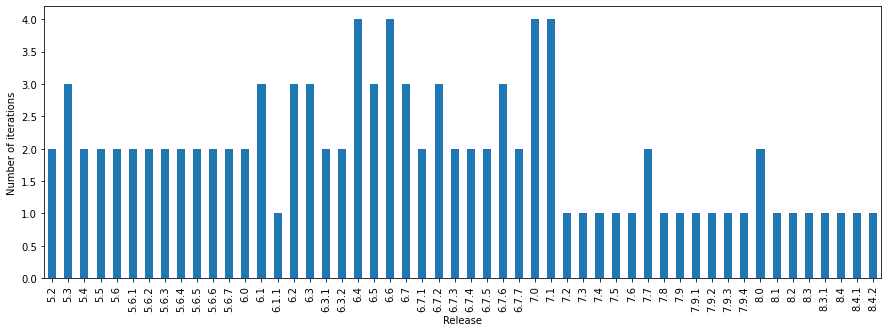

In [93]:
plt.figure()
ax = tags_pairs_iterations.set_index("to_tag").sort_index().n_iterations.plot(kind="bar")
ax.set(xlabel="Release", ylabel="Number of iterations")
plt.savefig(f"{figure_folder}/iterations_prs.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [94]:
tags_prs_iterative = pd.DataFrame(prs_data, columns=["from_tag", "to_tag", "pr_number"])
tags_prs_iterative.head()

,from_tag,to_tag,pr_number
0,5.1.2,5.2,475
1,5.1.2,5.2,499
2,5.1.2,5.2,462
3,5.1.2,5.2,496
4,5.1.2,5.2,464


In [96]:
builds_iterative_approach = pd.DataFrame(build_data, columns=["from_tag", "to_tag", "buildid"])

In [97]:
builds_iterative_approach = builds_iterative_approach.drop_duplicates(ignore_index=True)

In [98]:
builds_iterative_approach.to_csv(f"{csv_folder}/builds_per_release/builds_iterative_approach.csv")

In [99]:
builds_iterative_approach.shape

(48154, 3)

Text(0, 0.5, 'number of builds')

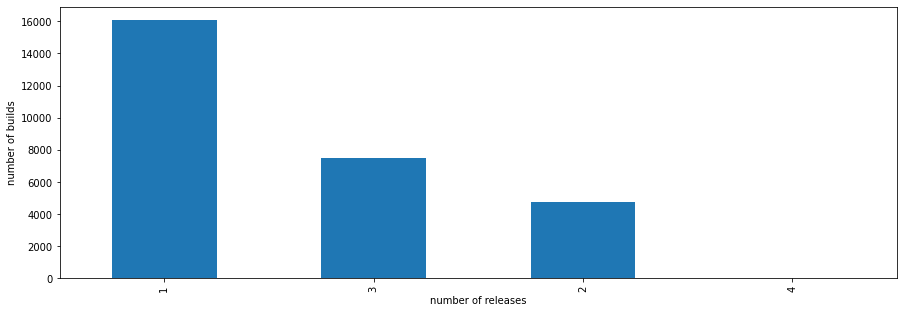

In [101]:
ax = builds_iterative_approach.groupby(["buildid"]).to_tag.count().value_counts().plot(kind="bar")
ax.set_xlabel("number of releases")
ax.set_ylabel("number of builds")

In [102]:
builds_iterative_approach.buildid.nunique() / len(builds)

0.7180239914966847

**Investigate included PRs**

Should we exclude the not merged ones?

In [103]:
prs_included = prs[prs.pr_number.isin(tags_prs_iterative.pr_number)]
prs_included[~prs_included.merged]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref


**Investigate not included PRs**

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='merged', ylabel='count'>

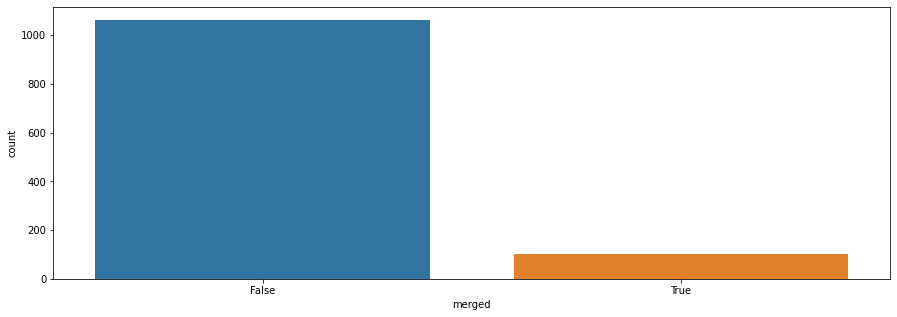

In [104]:
sns.countplot(prs[~prs.pr_number.isin(tags_prs_iterative.pr_number)].merged)

They are mostly not merged PRs. What about the merged ones?

In [105]:
prs[(~prs.pr_number.isin(tags_prs_iterative.pr_number)) \
    & (prs.created_at > pd.to_datetime("2015-03-05 14:39:13+00:00")) & (prs.merged)]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
351,2606,SONAR-9882,2017-10-02 15:03:40+00:00,2017-10-03 13:39:09+00:00,closed,True,0f7be9c7a2e04aec945dcb9f399e0962de2c1ce0,665c76ed3ff786ec84d51a61a825a048668dd3f4,feature/atlas/MMF-988/webhook_call_on_issue_ch...,b3d62bc8f6a41f3c089f115f37ef5849694ed6f5,feature/eh/SONAR-9882
372,2634,SONAR-9871 call project webhook on issue chang...,2017-10-09 09:22:14+00:00,2017-10-09 15:19:28+00:00,closed,True,9158491cca6240b4c0bfa66a87d122275b1af707,327dfa90bc92133bf903cee0619104220b197351,feature/atlas/MMF-988/webhook_call_on_issue_ch...,9158491cca6240b4c0bfa66a87d122275b1af707,feature/sl/SONAR-9871/call_project_webhook_on_...
412,3157,SONAR-9338 Make all date pickers consistent,2018-03-15 16:24:39+00:00,2018-03-16 15:24:04+00:00,closed,True,fd7209384d5f2d7ba3e23f36e9b330bb8f5b4234,9ee317bc4bf7de3cde6fad799d08e565630cc864,feature/full-react,e18524ff695bf0d4d90552258236da04dc2d06d9,feature/stas/datepicker
425,3151,Move VSTS extension to its own module,2018-03-13 16:51:22+00:00,2018-03-15 09:09:56+00:00,closed,True,360b53b020a193ff3c377779e0e69d2c5e91c75f,49c2d1701c09f9cca80c8fed6b0ef49327d5b0cc,feature/MMF-1123/vsts_integration,1dfe666aee64406626b563237349d2bf17f403cf,feature/greg/vsts_move_to_module
429,3152,Rewrite SelectList component in React on Quali...,2018-03-14 09:30:30+00:00,2018-03-16 15:21:30+00:00,closed,True,5b5b8896faa4f135c39ce894e7084a7e0a5f0f6f,9ee317bc4bf7de3cde6fad799d08e565630cc864,feature/full-react,e33fc12cd28cbd464977643483f1d251c2320686,feature/pm/rewriting-selectlist-in-react
444,3184,Corrected typo,2018-10-09 22:44:50+00:00,2018-10-15 18:50:28+00:00,closed,True,ed414e9ab4b47257bcf4e4462ee097dd4a2eb18a,a6e127b39f864078041f71552d51767f9bb374a5,master,e1f95b2763e52f72fbe855f170518a8621679f7e,patch-1
584,291,feature/fix_mssql_role,2015-05-05 20:47:30+00:00,2015-05-06 21:00:22+00:00,closed,True,053bdad7ba27899fa5eab6a99cdd6b10e5e941b4,543e5a352f60add1eeef61ad3c4dba7ce826bdb6,branch-4.5,f0d72ab12bda27a060554042db2d09b3e672a823,feature/fix_mssql_role
708,1915,Create members group when creating org,2017-04-10 14:56:38+00:00,2017-04-11 14:27:36+00:00,closed,True,627c7e7b9298d947a3965724f18e8648a5b4379c,c769fb54f7167b56fd603304feedd12a84393bc2,feature/lambda/add_default_group_in_organizations,627c7e7b9298d947a3965724f18e8648a5b4379c,feature/jl/create_members_group_when_creating_org
738,1934,"SONAR-9115 let api/rules/create fail, if organ...",2017-04-13 15:27:27+00:00,2017-04-14 07:00:06+00:00,closed,True,7557e66df346d698cd9894cd6ea785732a68a624,a7d3c82fa1c316c312ff7dbb9502bc1a82fd7665,feature/daniel/MMF-838/make_rules_ws_organizat...,1615b82d592912d9f87ff1fbf918a1f721eb9c48,feature/daniel/MMF-838/SONAR-9115/fail_custom_...
778,2984,SONAR-10313 change route and key of issue to i...,2018-01-25 09:45:12+00:00,2018-02-05 16:24:05+00:00,closed,True,f20057b318d07fdfd72f041f0d300874d614339b,76f37d0564f865e87d558b0169ce8424bc9cafcc,feature/MMF-1153/support_rule_key_renaming,f20057b318d07fdfd72f041f0d300874d614339b,feature/sl/7.1/SONAR-10313/remove_key_from_rul...


**Investigate not assigned builds**

In [181]:
builds = builds_sha[~builds_sha.buildid.isin(builds_iterative_approach.buildid.unique())]
builds

,buildid,commitsha,commitid,commitmessage,commitref,created_at
90,242404697,957b943f1559831f80845d1b293a0aa0cc833eac,70319990,Support recent browsers in Selenese HTML tests,refs/heads/feature/sb/selenese-chrome,2017-06-13 12:43:13.361000+00:00
91,242405185,b438ca00f05df5f54ea014f9706fbf317de2eb2c,70320158,Support recent browsers in Selenese HTML tests,refs/pull/2166/merge,2017-06-13 12:44:43.193000+00:00
106,181464351,9178026afd12c8cb45cd6b83af500c8b81de629a,51794052,SONAR-5471 drop data change migrations of 5.3,refs/heads/feature/sb/compress-ruby-migrations,2016-12-05 20:39:59.230000+00:00
107,181474724,1279b39395b2fe182fceaa5fa5e45f2a683b5cbe,51797140,SONAR-5471 remove data change migrations of 5.4,refs/heads/feature/sb/compress-ruby-migrations,2016-12-05 21:18:02.083000+00:00
108,181475284,71111ebad9da23121505eb3c46f4899ded562839,51797293,SONAR-5471 remove data change migrations of 5.4,refs/pull/1433/merge,2016-12-05 21:20:04.122000+00:00
...,...,...,...,...,...,...
39503,315383623,aa2e173fe7f47e568ef9ba2b5664e74eece38752,93633348,SONAR-10117 add test on error handling in Live...,refs/heads/feature/SONAR-10117/live-measures,2017-12-12 14:23:59.530000+00:00
39504,315384150,461a3e73bcbf17463b96e6ed512349a747e39942,93633511,SONAR-10117 add test on error handling in Live...,refs/heads/feature/SONAR-10117/live-measures,2017-12-12 14:24:59.934000+00:00
39505,315384395,9521be1f628b8a6c7275fbcf2275bc7aa84b99d0,93633590,SONAR-10117 add test on error handling in Live...,refs/pull/2901/merge,2017-12-12 14:25:30.462000+00:00
39512,315421138,04d5e19040df59e2a4a1025514c9b8b7c42378f8,93645831,SONAR-10187 Provide more options to populate e...,refs/heads/feature/stas/MMF-1128,2017-12-12 15:42:34.642000+00:00


## Include jobs with same commit message  (cherry picked commits)

In [255]:
tags_comparison_commits

,from_tag,to_tag,ahead_sha,commit_message,files_changed
0,4.5.6,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,Release 4.5.7,M\tplugins/sonar-core-plugin/pom.xml\nM\tplugi...
1,4.5.6,4.5.7,8cd20603bdbff2d725a3ba981839120b8d40faac,SONAR-7483 fix SSF,M\tserver/sonar-web/src/main/coffee/common/dia...
2,4.5.6,4.5.7,d0d9715a973793e5c8fc0ada606f70ffc7f08bf7,SONAR-7424 Fix for SSF-40 & SSF-41,M\tplugins/sonar-core-plugin/src/main/resource...
3,4.5.6,4.5.7,36d9a7959a95cbe44550e2c7790bf68d4c1066c8,SONAR-7424 Fix SSF-40 & SSF-41,M\tserver/sonar-web/src/main/webapp/WEB-INF/ap...
4,4.5.6,4.5.7,75d7c7ff807aa0c081935fe8c93095277e6fe497,SONAR-7424 Fix SSF-40 & SSF-41,M\tserver/sonar-web/src/main/webapp/WEB-INF/ap...
...,...,...,...,...,...
15600,8.4,8.4.1,08e36b12704d8ac30f56d3d5ecf73d5457424b5c,SONAR-13590 fix branch+snapshot comparator,M\tserver/sonar-webserver-core/src/main/java/o...
15601,8.4.1,8.4.2,2de1f343e3dbd9e88007b42e475512677c04eb8a,Release 8.4.2,M\tgradle.properties
15602,8.4.1,8.4.2,ed1a72601c559e86ccd96004c99157421b6bcb20,use try-with-ressource to write log4j ES prope...,M\tserver/sonar-main/src/main/java/org/sonar/a...
15603,8.4.1,8.4.2,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df,Use v2 of the github action release process,M\t.github/workflows/release.yml


In [182]:
no_cherry_pick = ["[maven-release-plugin] prepare for next development iteration",
                 "Prepare for next development iteration"]

def cherry_picked_from_jobs(from_tag, to_tag, _commits, _builds):
    res = []
    #for each commit
    for i, row in _commits.iterrows():
        commitmessage = row.commit_message
        if(not commitmessage.startswith("SONAR-")):
            continue
        if commitmessage in no_cherry_pick:
            return res
        sha = row.ahead_sha
        #if no date present skip
        if(len(commits_dates[commits_dates.commitsha==sha])==0):
            continue
        commit_date = commits_dates[commits_dates.commitsha==sha].iloc[0].date
        if(not commit_date):
            print("No date", sha)
            continue
        #jobs with same commitmessage but not same sh
        j = _builds[(_builds.commitmessage == commitmessage)&(_builds.commitsha != sha)]
        cherry_picked_candidates_shas = j.commitsha.unique()
        for cps in cherry_picked_candidates_shas:
            _cps_commits = commits_dates[commits_dates.commitsha==cps]
            if(len(_cps_commits) == 0):
                continue
            #keep only commits created before
            cps_date = _cps_commits.iloc[0].date
            if(commit_date < cps_date):
                continue
            files_changed = get_files_changed(cps)
            if(files_changed == row.files_changed):
                res.append((from_tag, to_tag, sha, cps))
    return res
    
def cherry_picked(row):
    from_tag = row.from_tag
    to_tag = row.to_tag
    #builds not already associated with this release
    bs = builds_sha[~builds_sha.buildid.isin(builds_iterative_approach[(builds_iterative_approach.from_tag==from_tag) & \
                            (builds_iterative_approach.to_tag==to_tag)].buildid.unique())]
    #commits diff for this release
    _commits = tags_comparison_commits[(tags_comparison_commits.from_tag==from_tag) & \
                            (tags_comparison_commits.to_tag==to_tag)]
    return cherry_picked_from_jobs(from_tag, to_tag, _commits, bs)

In [183]:
cherry_picked_data = []
for i, release in tags_comparison.iterrows():
    cherry_picked_data = cherry_picked_data + cherry_picked(release)
cherry_picked_commits = pd.DataFrame(cherry_picked_data, columns=["from_tag", "to_tag", "commitsha", "cherry_picked_origin_sha"])

In [184]:
len(cherry_picked_commits)

36

In [185]:
builds_cherry_rebased = cherry_picked_commits.merge(builds_sha[["buildid", "commitsha"]], \
                            left_on="cherry_picked_origin_sha", right_on="commitsha")\
.drop(columns=["commitsha_x", "commitsha_y", "cherry_picked_origin_sha"]).rename(columns={"id":"buildid"})

In [186]:
builds_cherry_rebased.append(builds_iterative_approach).buildid.nunique() / len(builds_sha)

0.7180746064685934

In [187]:
builds_cherry_rebased.append(builds_iterative_approach).shape

(48202, 3)

In [188]:
builds_cherry_rebased.append(builds_iterative_approach).to_csv(f"{csv_folder}/builds_per_release/builds_iterative_cherry_rebase.csv")

In [189]:
builds_cherry_rebased.append(builds_iterative_approach).shape

(48202, 3)

## Analysis of the selected methods

In [238]:
method1 = builds_from_direct_direct_pr
method2 = builds_cherry_rebased.append(builds_iterative_approach)

<Figure size 1080x360 with 0 Axes>

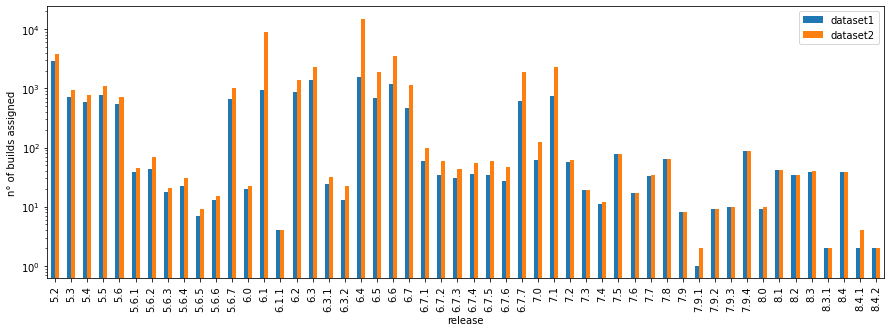

In [241]:
df_methods = tags_comparison.to_tag.reset_index()
df_methods["dataset1"] = method1.groupby("to_tag").buildid.count().values
df_methods["dataset2"] = method2.groupby("to_tag").buildid.count().values
plt.figure()
ax = df_methods.rename(columns={"to_tag":"release"}).set_index("release").sort_index()[["dataset1", "dataset2"]].plot(kind="bar", logy=True)
ax.set(xlabel='release', ylabel='n° of builds assigned')
plt.savefig(f"{figure_folder}/builds_per_release_methods.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

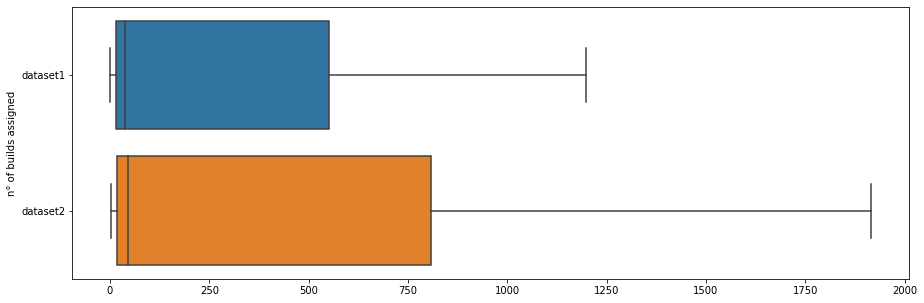

In [244]:
plt.figure()
ax = sns.boxplot(data=df_methods[["dataset1", "dataset2"]],orient="h", showfliers=False)
ax.set(ylabel='n° of builds assigned')
plt.savefig(f"{figure_folder}/builds_per_release_boxplots_methods.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [245]:
df_methods[["dataset1", "dataset2"]].describe()

,dataset1,dataset2
count,52.000000,52.000000
mean,302.153846,926.961538
std,544.178546,2485.796097
min,1.000000,2.000000
25%,16.000000,18.500000
50%,37.000000,45.500000
75%,550.000000,807.750000
max,2938.000000,15076.000000
